In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import pandas as pd
import numpy as np

import sys
sys.path.append('..')

from helpers import utils, pipelines, models

from sklearn.model_selection import train_test_split

import multiprocessing

from data_augmentaion.data_augmentator import DataAugmentor 

import json

import time

### Define research parameters

In [3]:
regression_task = True
continuous_features=['AGE', 'BMI', 'BP', 'S1', 'S2', 'S3', 'S4', 'S5', 'S6'] # not ['SEX']
metrics = ['neg_root_mean_squared_error', 'r2']
test_size_proportion = 0.2
augment_sample = 0.5

search_pipelines = pipelines.get_regression_pipelines()
search_parameters = models.regression_parameters

settings = [
    {'method': 'random'},
    {'method': 'smote'},
    {'method': 'cf_random'},
    # {'method': 'cf_genetic', 'kw_args': {'proximity_weight': 0.2, 'diversity_weight': 5, 'sparsity_weight': 0.2}},
    # {'method': 'cf_genetic', 'kw_args': {'proximity_weight': 0.2, 'diversity_weight': 5, 'sparsity_weight': 1}},
    {'method': 'cf_genetic', 'kw_args': {'proximity_weight': 7, 'diversity_weight': 0.2, 'sparsity_weight': 0.2}},
    # {'method': 'cf_genetic', 'kw_args': {'proximity_weight': 7, 'diversity_weight': 0.2, 'sparsity_weight': 1}},
    # {'method': 'cf_genetic', 'kw_args': {'proximity_weight': 1, 'diversity_weight': 1, 'sparsity_weight': 0.2}},
    # {'method': 'cf_genetic', 'kw_args': {'proximity_weight': 1, 'diversity_weight': 1, 'sparsity_weight': 1}},
    # {'method': 'cf_kdtree', 'kw_args': {'sparsity_weight': 0.2}},
    # {'method': 'cf_kdtree', 'kw_args': {'sparsity_weight': 1}},
]

### Read and preprocess data

In [4]:
df = pd.read_csv(r'../datasets/diabetes.txt', sep='\t')
target = 'Y'

#### split data

In [5]:
# all data
X = df.drop(target, axis=1)
y = df[target]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size_proportion, random_state=42)
df_train = pd.concat([X_train, y_train], axis=1)

<AxesSubplot:>

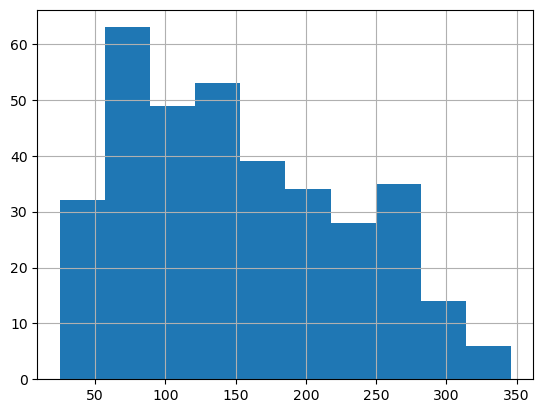

In [6]:
y_train.hist()

In [7]:
full_results_df = pd.DataFrame()

### Whole dataset scores

without augmentation scores:


whole          
      neg_root_mean_squared_error        r2
lr                      53.853446  0.452603
ridge                   53.842869  0.453519
lasso                   53.774196  0.454213
rf                      53.762652  0.454447
xgb                     53.924630  0.451155

<AxesSubplot:>

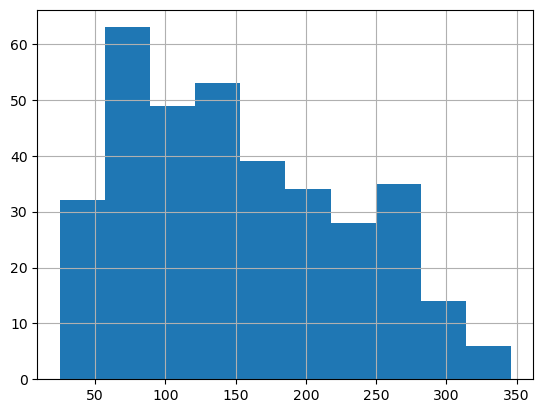

In [8]:
print(f'without augmentation scores:')
whole_best_ests, whole_scores = utils.fit_and_evaluate(X_train, y_train, X_test, y_test,
                    search_estimators=search_pipelines, search_params=search_parameters, scoring=metrics)
whole_dataset_result_df = pd.DataFrame.from_dict(whole_scores, orient='index')
whole_dataset_result_df.columns = pd.MultiIndex.from_product([['whole']] + [whole_dataset_result_df.columns])
display(whole_dataset_result_df)
y_train.hist()

In [9]:
full_results_df = pd.concat([full_results_df, whole_dataset_result_df], axis=1)

### running experiments

In [10]:
best_estimators = {}
best_scores = {}
total_time = time.time()
for i, s in enumerate(settings):
    start = time.time()
    print(f'{i+1} / {len(settings)}, {s}', end=' ')
    augmentor = DataAugmentor(X_train, y_train, X_test, y_test,
                             method=s['method'], regression=regression_task,
                             continuous_feats=continuous_features,
                             kw_args=s.get('kw_args', {})
                             )
    if s['method'][:2] != 'cf':
        X_train_augmented_balanced, y_train_augmented_balanced = augmentor.augment(balance=True)
        best_estimators[f'{i}_balanced'], best_scores[f'{i}_balanced'] = \
        utils.fit_and_evaluate(X_train_augmented_balanced, y_train_augmented_balanced, X_test, y_test,
                               search_estimators=search_pipelines, search_params=search_parameters, scoring=metrics)
        result_df_balanced = pd.DataFrame.from_dict(best_scores[f'{i}_balanced'], orient='index')
        result_df_balanced.columns = pd.MultiIndex.from_product([[f'{(list(s.values())[0])} balanced']] + [result_df_balanced.columns])
        # result_df_balanced.columns = pd.MultiIndex.from_product([[f'{json.dumps((list(s.values())))} balanced']] + [result_df_balanced.columns])


    X_train_augmented, y_train_augmented = augmentor.augment(balance=False, size=augment_sample)
    best_estimators[f'{i}'], best_scores[f'{i}'] = \
        utils.fit_and_evaluate(X_train_augmented, y_train_augmented, X_test, y_test,
                               search_estimators=search_pipelines, search_params=search_parameters, scoring=metrics)
    result_df = pd.DataFrame.from_dict(best_scores[f'{i}'], orient='index')
    result_df.columns = pd.MultiIndex.from_product([[f'{(list(s.values())[0])}']] + [result_df.columns])
    # result_df.columns = pd.MultiIndex.from_product([[f'{json.dumps((list(s.values())))}']] + [result_df.columns])
    

    full_results_df = pd.concat([full_results_df, result_df_balanced, result_df], axis=1)
    print(f'{time.time() - start} seconds for settings {i}')

print(f'\nTotal time: {time.time() - total_time}')

1 / 4, {'method': 'random'} 36.52112007141113 seconds for settings 0
2 / 4, {'method': 'smote'} 28.98621129989624 seconds for settings 1
3 / 4, {'method': 'cf_random'} model for cf neg_root_mean_squared_error score: {'cf': {'neg_root_mean_squared_error': 53.59294397603038}}
0/176


100%|██████████| 1/1 [00:00<00:00,  6.07it/s]


50/176


100%|██████████| 1/1 [00:00<00:00,  7.03it/s]


100/176


100%|██████████| 1/1 [00:00<00:00,  2.41it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec


100%|██████████| 1/1 [00:00<00:00,  7.77it/s]


150/176


100%|██████████| 1/1 [00:00<00:00,  6.28it/s]


62.84414553642273 seconds for settings 2
4 / 4, {'method': 'cf_genetic', 'kw_args': {'proximity_weight': 7, 'diversity_weight': 0.2, 'sparsity_weight': 0.2}} model for cf neg_root_mean_squared_error score: {'cf': {'neg_root_mean_squared_error': 53.59294397603038}}
0/176


100%|██████████| 1/1 [00:00<00:00,  5.08it/s]


50/176


100%|██████████| 1/1 [00:00<00:00,  7.50it/s]


100/176


100%|██████████| 1/1 [00:00<00:00,  6.05it/s]


150/176


100%|██████████| 1/1 [00:00<00:00,  6.00it/s]


53.332764863967896 seconds for settings 3

Total time: 181.684241771698


### results

In [11]:
full_results_df

whole                   ["random"] balanced  \
      neg_root_mean_squared_error        r2 neg_root_mean_squared_error   
lr                      53.853446  0.452603                   54.407337   
ridge                   53.842869  0.453519                   54.398790   
lasso                   53.774196  0.454213                   54.308541   
rf                      53.762652  0.454447                   53.811878   
xgb                     53.924630  0.451155                   54.198043   

                                 ["random"]            \
             r2 neg_root_mean_squared_error        r2   
lr     0.441285                   54.329898  0.442874   
ridge  0.441460                   54.305594  0.443372   
lasso  0.443312                   54.266014  0.444183   
rf     0.453447                   52.980496  0.470205   
xgb    0.445575                   63.883239  0.254359   

               ["smote"] balanced                             ["smote"]  \
      neg_root_mean_squared_error        r2 neg_root_mean_squared_error   
lr                      54.042278  0.448757                   54.325113   
ridge                   54.034443  0.448917                   54.320280   
lasso                   53.948500  0.450669                   54.184454   
rf                      53.179822  0.466211                   53.730088   
xgb                     57.079989  0.385045                   53.364110   

                         ["smote"] balanced            \
             r2 neg_root_mean_squared_error        r2   
lr     0.442972                   54.042278  0.448757   
ridge  0.444925                   54.034443  0.448917   
lasso  0.450669                   53.948500  0.450669   
rf     0.455108                   53.179822  0.466211   
xgb    0.462505                   57.079989  0.385045   

                    ["cf_random"]                    ["smote"] balanced  \
      neg_root_mean_squared_error        r2 neg_root_mean_squared_error   
lr                      53.449001  0.460794                   54.042278   
ridge                   53.443422  0.460906                   54.034443   
lasso                   52.771352  0.474380                   53.948500   
rf                      53.201920  0.465768                   53.179822   
xgb                     52.980514  0.484288                   57.079989   

                 \
             r2   
lr     0.448757   
ridge  0.448917   
lasso  0.450669   
rf     0.466211   
xgb    0.385045   

      ["cf_genetic", {"proximity_weight": 7, "diversity_weight": 0.2, "sparsity_weight": 0.2, "total_CFs": 1, "desired_range": [187.06190176609644, 265.1238035321929]}]  \
                                                                                                                                             neg_root_mean_squared_error   
lr                                             54.148440                                                                                                                   
ridge                                          54.133437                                                                                                                   
lasso                                          53.740643                                                                                                                   
rf                                             54.397829                                                                                                                   
xgb                                            52.409159                                                                                                                   

                 
             r2  
lr     0.446589  
ridge  0.446896  
lasso  0.454894  
rf     0.441480  
xgb    0.473175

In [12]:
print('best methods')
best_methods = pd.DataFrame()
for s in metrics:
    models_scores = full_results_df.xs(s, axis='columns', level=1)
    if s.split('_')[-1] == 'error':
        greater_models = models_scores.idxmin(axis='columns') 
        greater_models['overall'] = models_scores.min(axis=0).idxmin(axis=0)
    else:
        greater_models = models_scores.idxmax(axis='columns')
        greater_models['overall'] = models_scores.max(axis=0).idxmax(axis=0)

    greater_models.name = s
    best_methods = pd.concat([best_methods, greater_models], axis=1)
best_methods

best methods


,neg_root_mean_squared_error,r2
lr,"[""cf_random""]","[""cf_random""]"
ridge,"[""cf_random""]","[""cf_random""]"
lasso,"[""cf_random""]","[""cf_random""]"
rf,"[""random""]","[""random""]"
xgb,"[""cf_genetic"", {""proximity_weight"": 7, ""divers...","[""cf_random""]"
overall,"[""cf_genetic"", {""proximity_weight"": 7, ""divers...","[""cf_random""]"


In [13]:
full_results_df.to_csv(rf'../log/experiment_regression_testsize{test_size_proportion}_augmentsample{augment_sample}.csv')